In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, trigger_onset

In [2]:
train_data_path = './data/lunar/training/data/S12_GradeA/'
catalog_file_path = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
catalog_df = pd.read_csv(catalog_file_path)

In [3]:
def load_velocity_and_labels_with_amplitude_change(train_data_path, catalog_df):
    X_data = []
    y_data = []  # y_data에 실제 지진 발생 시점을 저장

    for index, row in catalog_df.iterrows():
        filename = row['filename']
        ansTime = row['time_rel(sec)']  # 지진 발생 시점 (초 단위)
        file_path = os.path.join(train_data_path, f"{filename}.csv")

        # velocity 데이터 로드
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            velocity_data = data['velocity(m/s)'].values

            # 진폭 변화량 계산 (절대 차이)
            amplitude_change = np.abs(velocity_data)
            
            # ansTime을 샘플 인덱스로 변환
            ansTime_idx = int(ansTime * (len(amplitude_change) / 86400))  # 상대 시간(초)을 샘플 인덱스로 변환

            # 샘플링 간격 조정
            if ansTime_idx < 20000:
                amplitude_change = amplitude_change[0:100000]
            elif len(amplitude_change) - ansTime_idx < 80000:
                ansTime_idx -= len(amplitude_change) - 100000
                amplitude_change = amplitude_change[len(amplitude_change)-100000:len(amplitude_change)]
            else:
                amplitude_change = amplitude_change[ansTime_idx-20000:ansTime_idx+80000]
                ansTime_idx = 20000
            amplitude_change = amplitude_change[::10]

            X_data.append(amplitude_change)

            # 정답 데이터로 지진 발생 시점을 저장
            y_data.append(ansTime_idx)  # 샘플 인덱스 사용


    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data  # 데이터 반환

In [4]:
X_saved, y_saved = load_velocity_and_labels_with_amplitude_change(train_data_path, catalog_df)
y_saved = y_saved // 10

In [5]:
X = X_saved
y = y_saved

In [6]:
print(X)
print(y)

[[3.51000000e-10 1.04000000e-10 8.15000000e-11 ... 2.77000000e-11
  2.45000000e-11 6.67000000e-11]
 [1.28000000e-10 3.07000000e-10 3.71000000e-10 ... 1.99000000e-10
  1.99000000e-10 2.54000000e-10]
 [3.90000000e-10 4.36000000e-10 1.41000000e-10 ... 1.75000000e-10
  2.36000000e-10 1.67000000e-10]
 ...
 [6.08202886e-11 2.80527970e-10 3.23802918e-10 ... 3.16153921e-10
  9.71414576e-11 9.04323963e-11]
 [2.44496342e-10 2.04967739e-11 1.56310447e-10 ... 1.29428379e-10
  5.17166740e-10 2.12060947e-10]
 [3.75158779e-10 1.39569843e-10 4.79569651e-10 ... 7.67234501e-13
  1.24489176e-11 4.47463138e-12]]
[2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 6024 2000 2000 2000
 2000 2000 2000 2000 2000 2000 2000 2000 5071 2000 2000 2000 2000 7654
 1748 2000 2000 2000 1749 2000 2000 2000 2000 2000 2000 2000 2000 8847
 2000 8449 2000 6422 2000 2000 2000 2000 2000  914 2000 2000 2000 2000
 2000 2000 2000 2000]


[2037 2379]
Detected triggers (start, end samples): [[2037 2379]
 [6293 6340]
 [6796 6943]
 [7208 7269]
 [7875 7953]
 [8332 8409]
 [8606 8778]
 [8839 8903]
 [9328 9404]
 [9475 9658]]


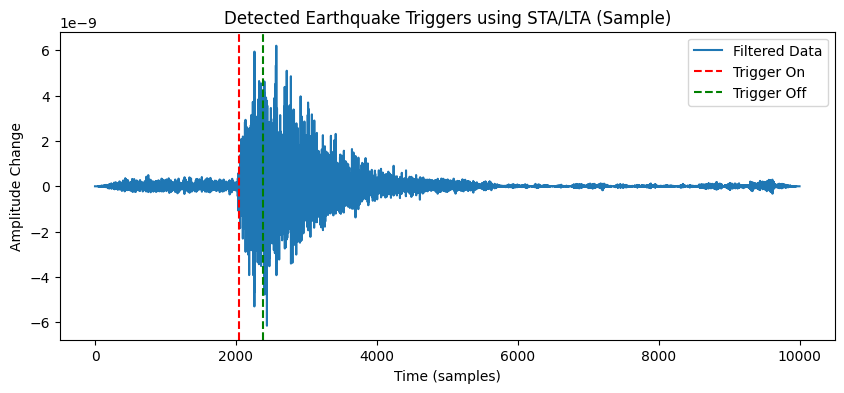

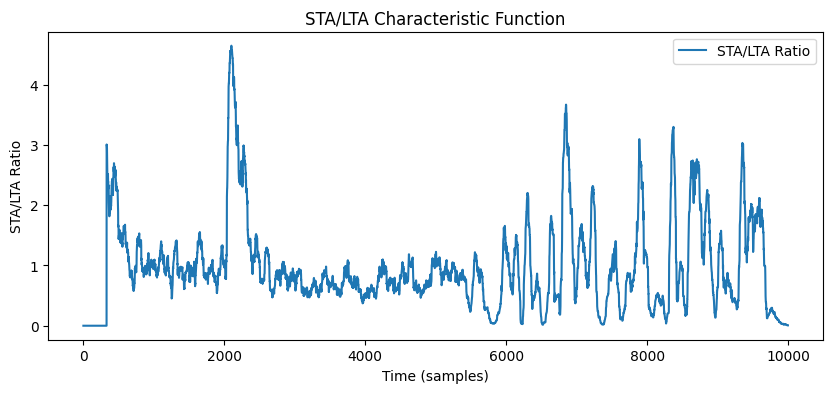

In [7]:
sampling_rate = 6.625

# STA/LTA 윈도우 크기 (초 단위로 설정)
sta_seconds = 10   # 10초 단기 평균
lta_seconds = 50   # 50초 장기 평균

# 샘플레이트에 맞는 윈도우 크기 변환
sta_window = int(sta_seconds * sampling_rate)
lta_window = int(lta_seconds * sampling_rate)

# 노이즈 제거 및 전처리 (Cosine taper 및 Highpass 필터 적용)
def preprocess_signal(data, sampling_rate):
    # Cosine taper 적용 (경계 처리를 부드럽게 하기 위함)
    taper = cosine_taper(len(data), 0.1)
    data = data * taper
    
    # 고역 통과 필터 적용 (1Hz 이상 노이즈 제거)
    filtered_data = highpass(data, freq=1.0, df=sampling_rate, corners=4, zerophase=True)
    
    return filtered_data

# STA/LTA 알고리즘을 사용해 지진 발생 시점 탐지
def detect_earthquake_with_sta_lta(data, sta_window, lta_window, threshold_on=2.0, threshold_off=1.2):
    # STA/LTA 계산 (classic_sta_lta 사용)
    cft = classic_sta_lta(data, sta_window, lta_window)
    
    # STA/LTA 트리거 감지
    triggers = trigger_onset(cft, threshold_on, threshold_off)
    
    return cft, triggers

def find_largest_trigger(triggers):
    if len(triggers) == 0:
        return None
    # 각 트리거의 on-off 차이 계산
    trigger_durations = [(trigger[1] - trigger[0], trigger) for trigger in triggers]
    # on-off 차이가 가장 큰 트리거 선택
    largest_trigger = max(trigger_durations, key=lambda k: k[0])[1]
    return largest_trigger

interval = []
charfunc = []

for i in range(len(X)):
    # 노이즈 제거 전처리 과정 적용
    preprocessed_data = preprocess_signal(X[i], sampling_rate)
    
    # STA/LTA 알고리즘 적용
    cft, triggers = detect_earthquake_with_sta_lta(preprocessed_data, sta_window, lta_window)
    
    # 트리거가 존재하는 경우에만 처리
    if len(triggers) > 0:
        # numpy 배열 처리
        triggers = np.array(triggers)
        triggers = triggers[triggers[:, 0] != 330]  # 트리거 필터링

    charfunc.append(cft)
    interval.append(triggers)
    
    # 트리거 중 가장 큰 트리거 찾기
    trigger = find_largest_trigger(triggers)
    
    # 특정 인덱스에 대해 결과 시각화
    if i == 5:
        print(trigger)

        print(f"Detected triggers (start, end samples): {triggers}")

        plt.figure(figsize=(10, 4))
        plt.plot(preprocessed_data, label='Filtered Data')
        
        if trigger is not None:
            plt.axvline(x=trigger[0], color='red', linestyle='--', label='Trigger On')
            plt.axvline(x=trigger[1], color='green', linestyle='--', label='Trigger Off')
        
        plt.title(f"Detected Earthquake Triggers using STA/LTA (Sample)")
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude Change')
        plt.legend()
        plt.show()

        # STA/LTA 비율 시각화
        plt.figure(figsize=(10, 4))
        plt.plot(cft, label='STA/LTA Ratio')
        plt.title('STA/LTA Characteristic Function')
        plt.xlabel('Time (samples)')
        plt.ylabel('STA/LTA Ratio')
        plt.legend()
        plt.show()


In [8]:
for i in range(len(X)):
    flag = False
    for x in interval[i]:
        if y[i] in range(x[0]-500, x[1]):
            flag = True
    if flag == False:
        print(i, end=' ')
        print(interval[i], end=' ')
        print(y[i])

In [12]:
# 데이터 준비
# 각 데이터는 (ampl, ratio, duration) 형식
X_train = []
y_train = [0]*len(X)
for i in range(len(X)):
    large_tmp = []
    for x in interval[i]:
        tmp = [0,0,0]
        tmp[0] = np.max(X[i][x[0]:x[1]]) * 1e9
        tmp[1] = np.max(charfunc[i][x[0]:x[1]])
        tmp[2] = (x[1] - x[0]) / 100
        if y[i] in range(x[0]-500, x[1]):
            y_train[i] = tmp.copy()
        elif x[1] - x[0] < 150:
            continue
        large_tmp.append(tmp)
    X_train.append(large_tmp)

print(X_train)
print(y_train)
print(len(y_train))

# X_train을 (ampl, ratio, duration)로 분리
ampl = []
ratio = []
duration = []
for group in X_train:
    ampl.extend([x[0] for x in group])
    ratio.extend([x[1] for x in group])
    duration.extend([x[2] for x in group])

[[[7.87, 4.834181510333762, 4.23]], [[4.2, 3.138114744385124, 4.34]], [[6.14, 3.909155481182367, 4.01]], [[5.386065455958148, 4.017196992596382, 3.01]], [[4.542430087973785, 3.9427300131657828, 2.48], [1.937204021404175, 2.228893002850956, 2.11]], [[13.27453534015848, 4.644308109551481, 3.42], [0.3001210344848557, 2.7612115071279324, 1.72], [1.4279094069383451, 2.1170139445447536, 1.83]], [[30.95898860762659, 4.664072020469148, 3.28]], [[16.720904768857668, 4.122557504081547, 4.1]], [[1.6419959774488682, 3.868730383118115, 6.08], [5.320810717363669, 4.474750997676633, 2.43]], [[0.654035075552538, 3.2804346288131514, 2.12], [3.9893334930214244, 3.934064315131407, 2.41]], [[3.218385048131596, 2.5887225699693164, 3.05], [0.6751750437622535, 4.786673572356637, 1.6]], [[5.325911455737198, 3.530002674868387, 3.6]], [[3.8883663471154026, 5.004446561293472, 5.7]], [[4.933840047708657, 4.099576353448657, 2.94]], [[4.707409579472935, 4.641383848704006, 2.39]], [[0.14774670992040348, 3.6861702101

In [9]:
# X_input 데이터 준비
X_input = np.column_stack((ampl, ratio, duration))

# 각 그룹에서 정답 인덱스를 찾기 위한 코드
y_indices = []
for i, group in enumerate(X_train):
    for idx, val in enumerate(group):
        if np.allclose(val, y_train[i]):
            y_indices.append(idx)
            break

# 모델 정의
input_data = Input(shape=(3,))
dense1 = Dense(64, activation='relu')(input_data)
dropout1 = Dropout(0.05)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.05)(dense2)
output = Dense(1, use_bias=False)(dropout2)

model = Model(inputs=input_data, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Custom loss 함수 정의
def ranking_loss(y_true, y_pred):
    loss = 0
    start = 0
    for i, group in enumerate(X_train):
        end = start + len(group)
        group_preds = y_pred[start:end]
        correct_pred = group_preds[y_indices[i]]
        for j in range(len(group)):
            if j != y_indices[i]:
                loss += tf.maximum(0.0, 1.0 - (correct_pred - group_preds[j]))
        start = end
    return loss

model.fit(X_input, np.zeros(len(X_input)), epochs=100, verbose=2, batch_size=32)
weights = model.get_weights()
dense_weights = weights[0].flatten()

a, b, c = dense_weights[:3]
print(f"Learned parameters: a={a}, b={b}, c={c}")



In [13]:
a=0.22672614455223083
b=-0.029509663581848145
c=0.0457753948867321

In [26]:
ans_val_list = []
for ans in y_train:
    ans_val_list.append(a*ans[0]+b*ans[1]+c*ans[2])
print(ans_val_list)
ans_val_list.sort()
eq_bound = ans_val_list[int(len(y_train)*0.5)]
print(eq_bound)

[1.8353096079333937, 1.0583103105397444, 1.4602999979076634, 1.2403996619508764, 1.0270620037808647, 3.0291840990257786, 7.0317202252265405, 3.8570901056614413, 1.1855527128608365, 0.8987119894339741, 0.7929146559054236, 1.2681456007996994, 0.9948345269053824, 1.132233073803001, 1.0397303426319475, 1.099257387919367, 0.868941403407717, 0.8897179908839474, 0.7717327575873731, 0.6260360242600043, 6.252347021001518, 1.667936821719631, 1.9057848576084615, 0.6138553205998081, 25.070024845314716, 29.915302244765602, 0.5717056643313607, 0.9973301401695263, 10.509450881877642, 1.1552937972704478, 0.8095316083297714, 1.2265961749035035, 0.77125188117122, 1.526676914024776, 0.7154924835269153, 0.8123799479936162, 4.083286224194515, 0.6924265772420635, 1.7702846666369223, 0.7027515157856917, 0.6459191424142172, 0.4831050453287776, 0.5074921054275283, 0.4287907177340455, 0.12872639075380926, 0.9064457147573022, 1.1247046123925928, 0.6311657842256173, 0.759106228654291, 0.7265112433736004, 0.739197

In [15]:
print(X_train[0])
print(y_train[0])

[[7.87, 4.834181510333762, 4.23]]
[7.87, 4.834181510333762, 4.23]


In [16]:
cnt = 0
wrong = 0
for i in range(len(X)):
    ans = []
    Max = -1e9
    for x in X_train[i]:
        yo = a*x[0] + b*x[1] + c*x[2]
        yo = yo.astype(np.float32)
        if yo > Max:
            Max = yo
            ans = x
    print(ans, y_train[i])
    if ans == y_train[i]:
        cnt += 1
    else:
        wrong += 1
        print(i)

print(cnt, wrong)

[7.87, 4.834181510333762, 4.23] [7.87, 4.834181510333762, 4.23]
[4.2, 3.138114744385124, 4.34] [4.2, 3.138114744385124, 4.34]
[6.14, 3.909155481182367, 4.01] [6.14, 3.909155481182367, 4.01]
[5.386065455958148, 4.017196992596382, 3.01] [5.386065455958148, 4.017196992596382, 3.01]
[4.542430087973785, 3.9427300131657828, 2.48] [4.542430087973785, 3.9427300131657828, 2.48]
[13.27453534015848, 4.644308109551481, 3.42] [13.27453534015848, 4.644308109551481, 3.42]
[30.95898860762659, 4.664072020469148, 3.28] [30.95898860762659, 4.664072020469148, 3.28]
[16.720904768857668, 4.122557504081547, 4.1] [16.720904768857668, 4.122557504081547, 4.1]
[5.320810717363669, 4.474750997676633, 2.43] [5.320810717363669, 4.474750997676633, 2.43]
[3.9893334930214244, 3.934064315131407, 2.41] [3.9893334930214244, 3.934064315131407, 2.41]
[3.218385048131596, 2.5887225699693164, 3.05] [3.218385048131596, 2.5887225699693164, 3.05]
[5.325911455737198, 3.530002674868387, 3.6] [5.325911455737198, 3.530002674868387, 3

In [17]:
test_data_path = './data/lunar/training/data/S12_GradeB/'

In [18]:
def load_velocity_and_labels_with_amplitude_change_test(test_data_path):
    t_data = []

    for file_name in os.listdir(test_data_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(test_data_path, file_name)
            data = pd.read_csv(file_path)
            velocity_data = data['velocity(m/s)'].values
            amplitude_change = np.abs(velocity_data)
            amplitude_change = amplitude_change[::10]
            t_data.append(amplitude_change)

    return t_data

In [19]:
test_saved = load_velocity_and_labels_with_amplitude_change_test(train_data_path)

In [20]:
T = test_saved

In [21]:
print(T)

[array([6.15e-14, 8.59e-15, 2.90e-14, ..., 3.27e-14, 4.85e-14, 1.47e-14]), array([5.48e-15, 7.96e-16, 2.57e-15, ..., 3.12e-15, 1.28e-14, 3.47e-15]), array([2.82e-14, 6.44e-15, 1.14e-14, ..., 7.81e-15, 4.36e-14, 1.86e-14]), array([9.01642265e-15, 1.32366015e-15, 4.27261119e-15, ...,
       4.97613178e-15, 1.17339951e-14, 4.55561713e-15]), array([1.58356538e-16, 1.99477744e-17, 5.45991860e-17, ...,
       2.17333589e-15, 4.38996969e-15, 1.67617591e-15]), array([8.04257635e-16, 3.18994337e-17, 1.35117971e-16, ...,
       3.17487390e-16, 3.22659121e-18, 9.02340349e-16]), array([6.72797656e-16, 8.99854976e-17, 1.84636744e-16, ...,
       4.18052797e-16, 8.99725122e-16, 2.79695512e-17]), array([1.46215450e-15, 1.53203105e-16, 7.13590852e-16, ...,
       3.88414727e-16, 2.24229649e-15, 1.02868370e-15]), array([1.46215450e-15, 1.53203105e-16, 7.13590852e-16, ...,
       3.88414727e-16, 2.24229649e-15, 1.02868370e-15]), array([1.74335360e-16, 5.94966580e-17, 1.01529677e-16, ...,
       1.222827

[8582 8945]
Detected triggers (start, end samples): [[  857   957]
 [ 1046  1201]
 [ 1242  1350]
 [ 1430  1545]
 [ 1768  1844]
 [ 2229  2359]
 [ 8582  8945]
 [11934 12015]
 [20773 20810]
 [27902 27967]
 [28770 28799]
 [29099 29142]
 [29834 29899]
 [30169 30254]
 [31022 31031]
 [31604 31648]
 [32637 32690]
 [34301 34335]
 [50773 50852]
 [52861 52972]
 [53515 53579]]


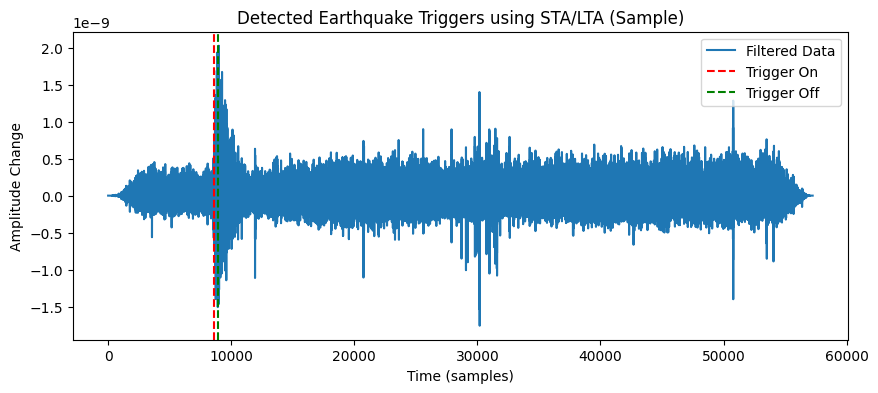

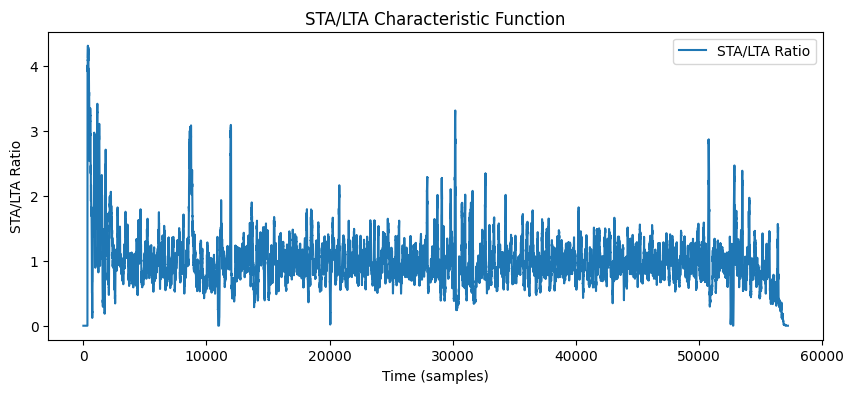

In [22]:
interval_t = []
charfunc_t = []

for i in range(len(T)):
    # 노이즈 제거 전처리 과정 적용
    preprocessed_data = preprocess_signal(T[i], sampling_rate)
    
    # STA/LTA 알고리즘 적용
    cft, triggers = detect_earthquake_with_sta_lta(preprocessed_data, sta_window, lta_window)
    
    # 트리거가 존재하는 경우에만 처리
    if len(triggers) > 0:
        # numpy 배열 처리
        triggers = np.array(triggers)
        triggers = triggers[triggers[:, 0] != 330]  # 트리거 필터링

    charfunc_t.append(cft)
    interval_t.append(triggers)
    
    # 트리거 중 가장 큰 트리거 찾기
    trigger = find_largest_trigger(triggers)
    
    # 특정 인덱스에 대해 결과 시각화
    if i == 1:
        print(trigger)

        print(f"Detected triggers (start, end samples): {triggers}")

        plt.figure(figsize=(10, 4))
        plt.plot(preprocessed_data, label='Filtered Data')
        
        if trigger is not None:
            plt.axvline(x=trigger[0], color='red', linestyle='--', label='Trigger On')
            plt.axvline(x=trigger[1], color='green', linestyle='--', label='Trigger Off')
        
        plt.title(f"Detected Earthquake Triggers using STA/LTA (Sample)")
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude Change')
        plt.legend()
        plt.show()

        # STA/LTA 비율 시각화
        plt.figure(figsize=(10, 4))
        plt.plot(cft, label='STA/LTA Ratio')
        plt.title('STA/LTA Characteristic Function')
        plt.xlabel('Time (samples)')
        plt.ylabel('STA/LTA Ratio')
        plt.legend()
        plt.show()


In [27]:
T_train = []
for i in range(len(T)):
    large_tmp = []
    for x in interval_t[i]:
        tmp = [0,0,0,0]
        tmp[0] = np.max(T[i][x[0]:x[1]]) * 1e9
        tmp[1] = np.max(charfunc_t[i][x[0]:x[1]])
        tmp[2] = (x[1] - x[0]) / 100
        tmp[3] = [x[0], x[1]]
        if x[1] - x[0] < 150:
            continue
        large_tmp.append(tmp)
    T_train.append(large_tmp)

print(len(T_train))
print(len(T))

# X_train을 (ampl, ratio, duration)로 분리
ampl = []
ratio = []
duration = []
for group in T_train:
    ampl.extend([x[0] for x in group])
    ratio.extend([x[1] for x in group])
    duration.extend([x[2] for x in group])

75
75


In [24]:
for i in T_train[1]:
    print(i)

[0.29500000000000004, 3.420922368108603, 1.55, [1046, 1201]]
[3.52, 3.087704056714356, 3.63, [8582, 8945]]


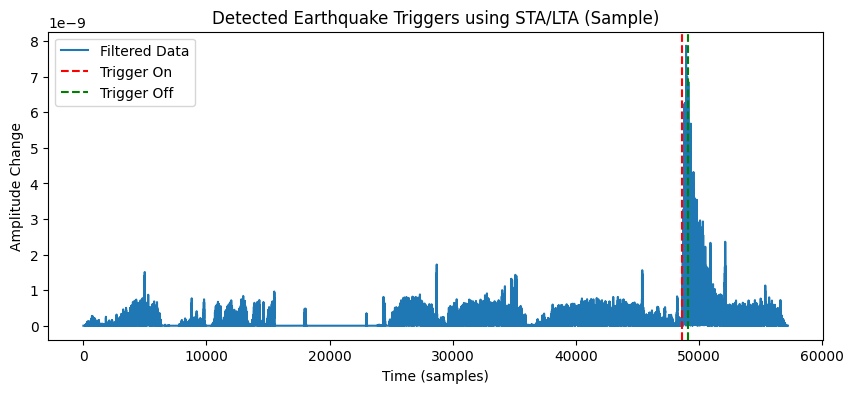

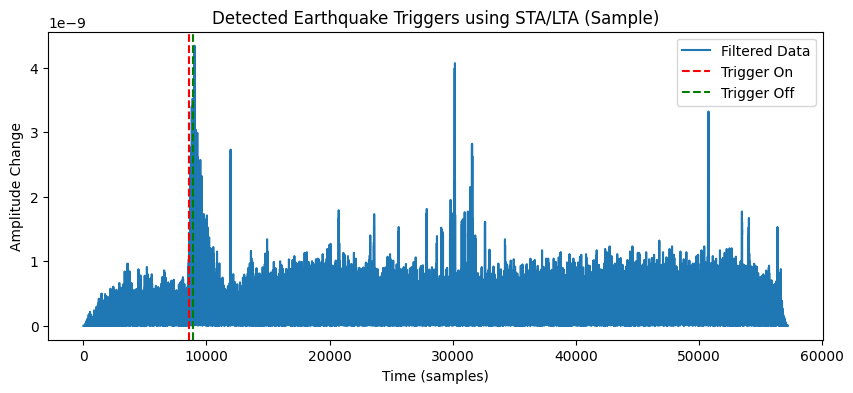

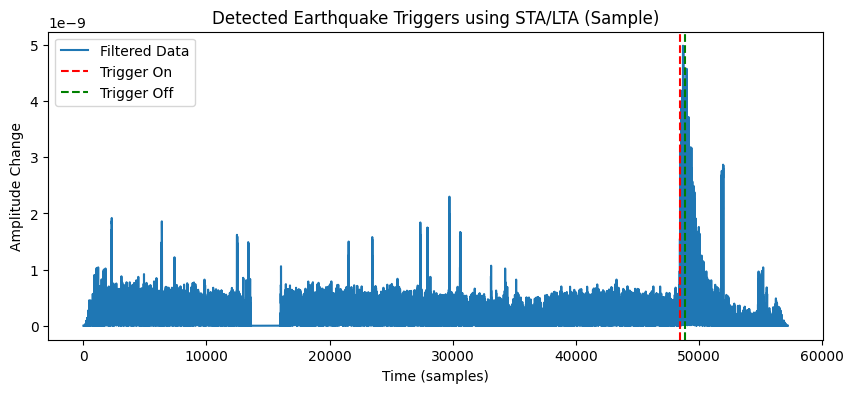

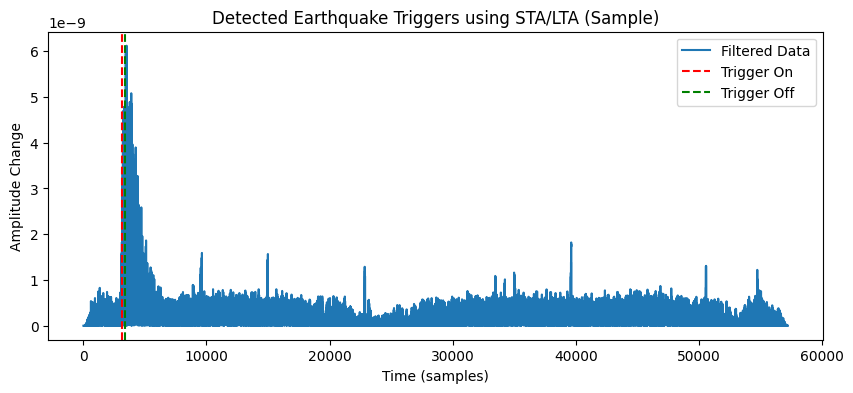

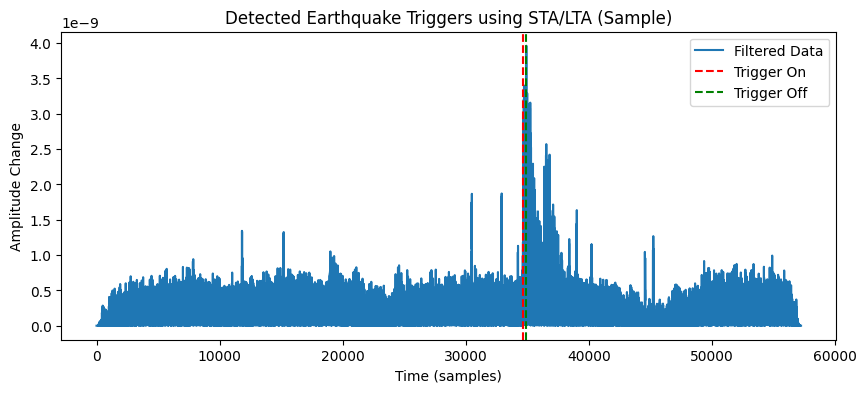

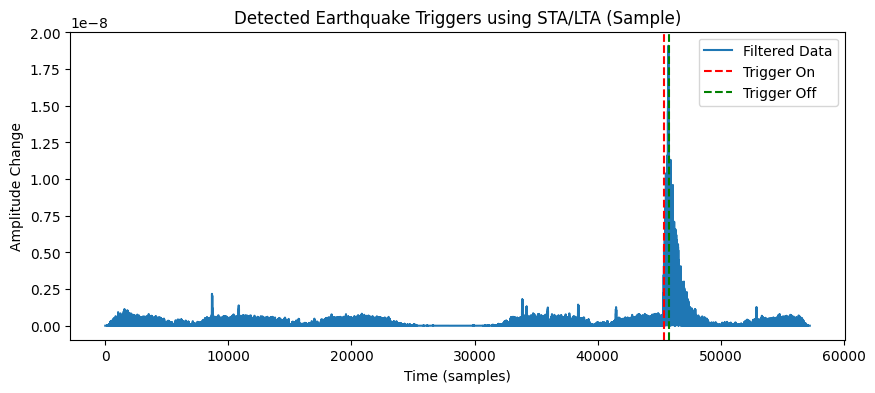

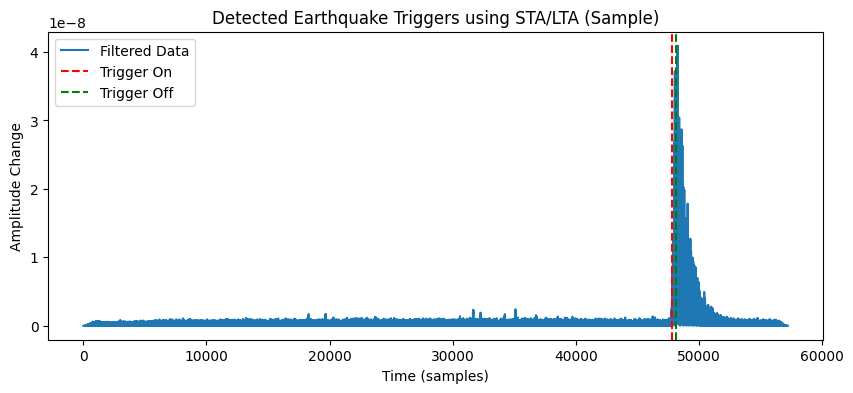

7 [[12202, 12630], [28012, 28269]]


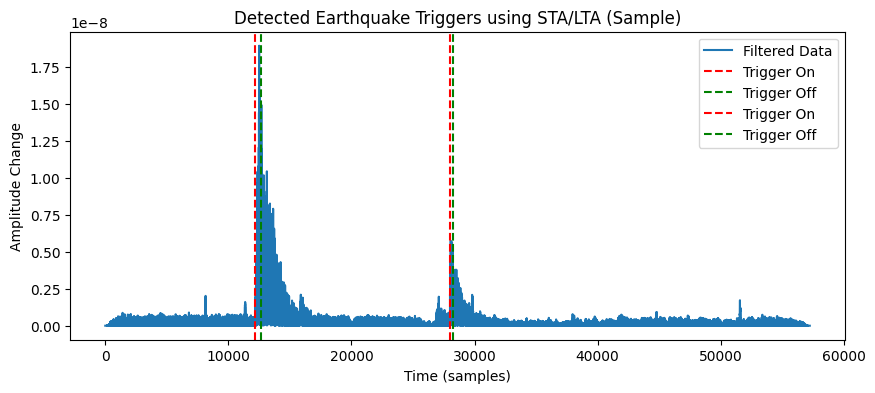

8 [[12202, 12630], [28012, 28269]]


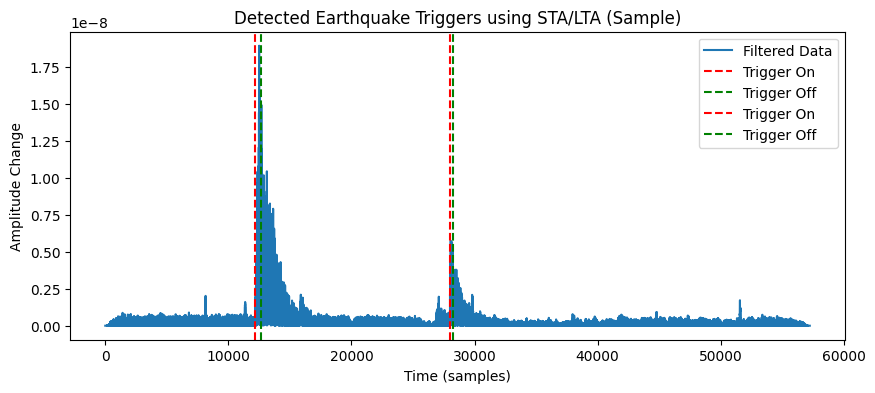

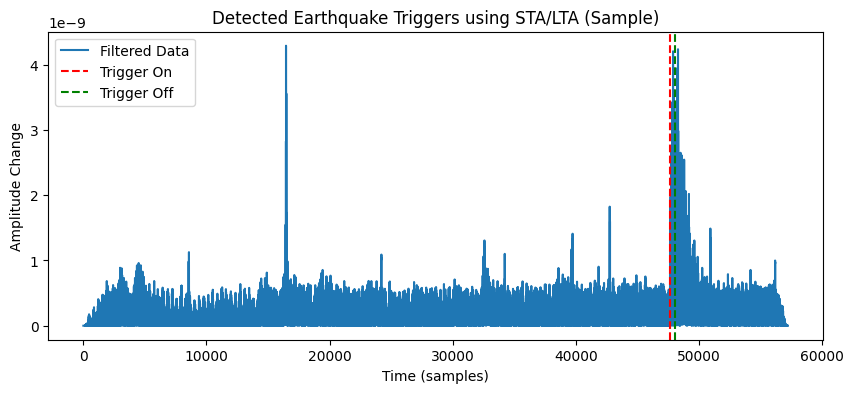

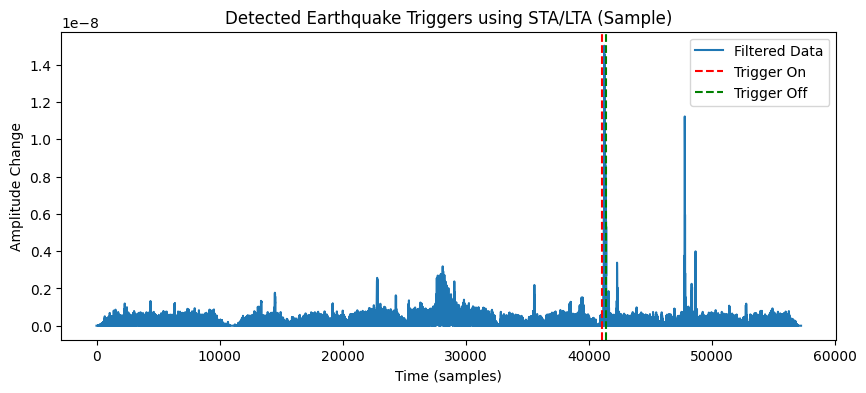

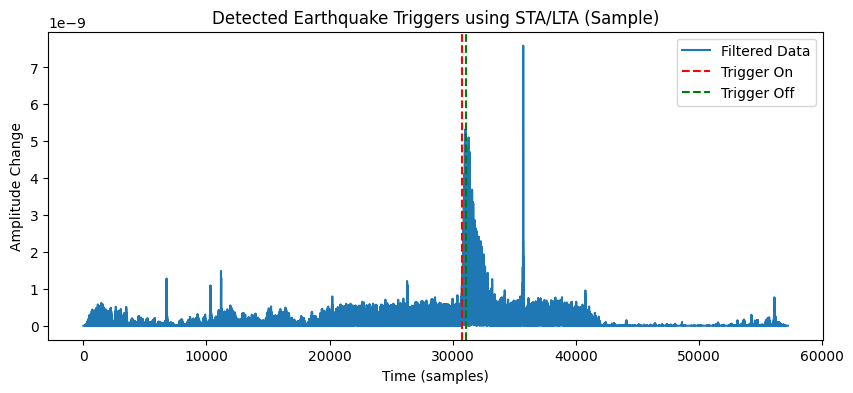

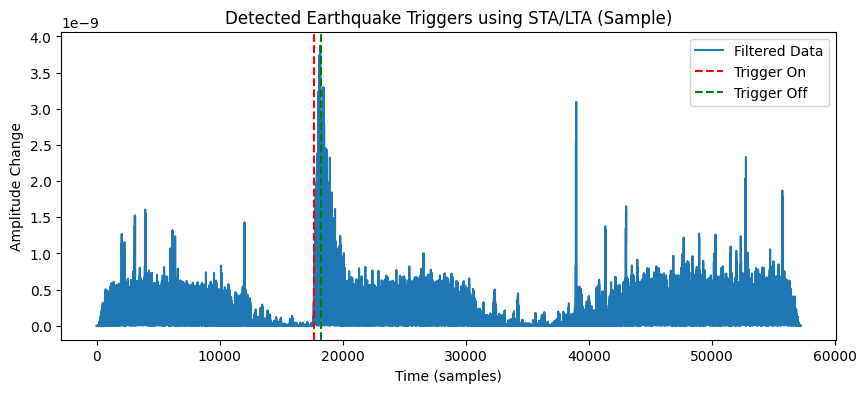

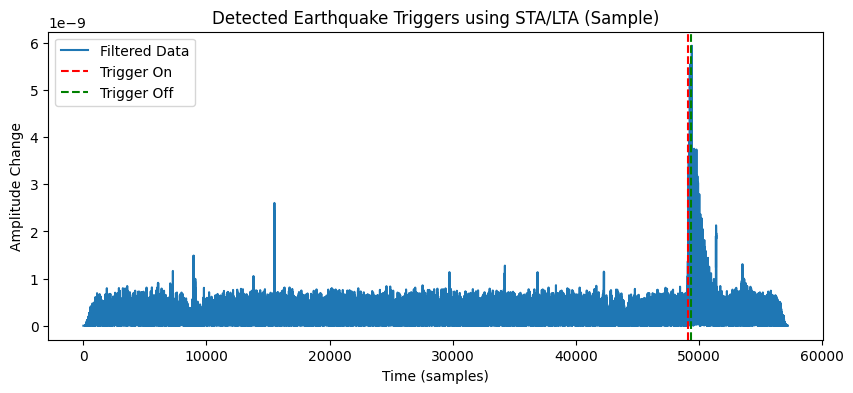

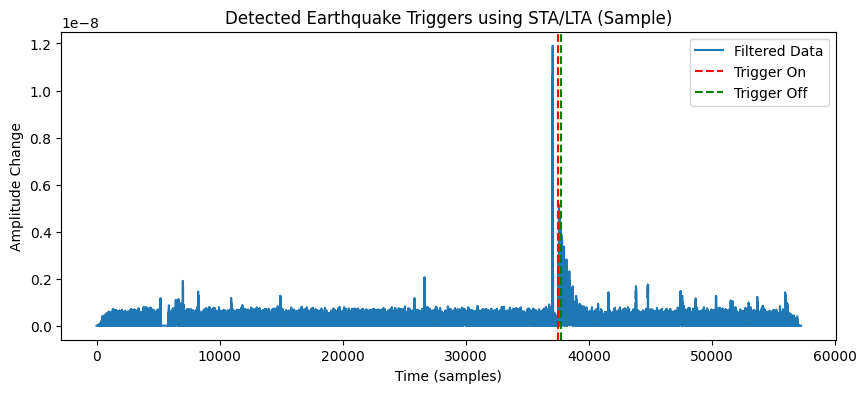

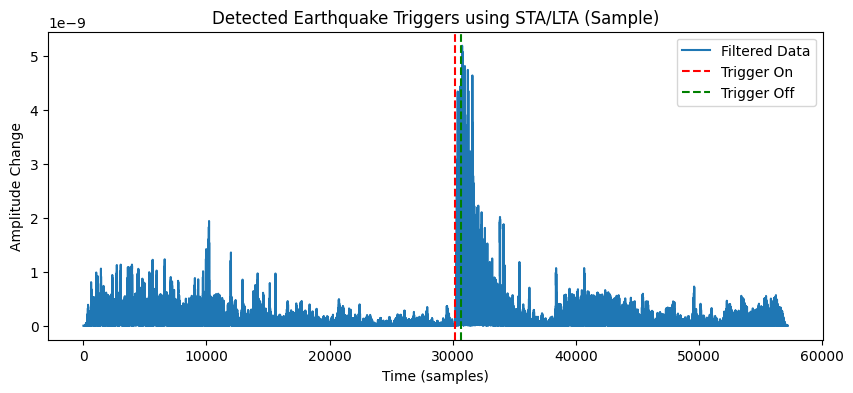

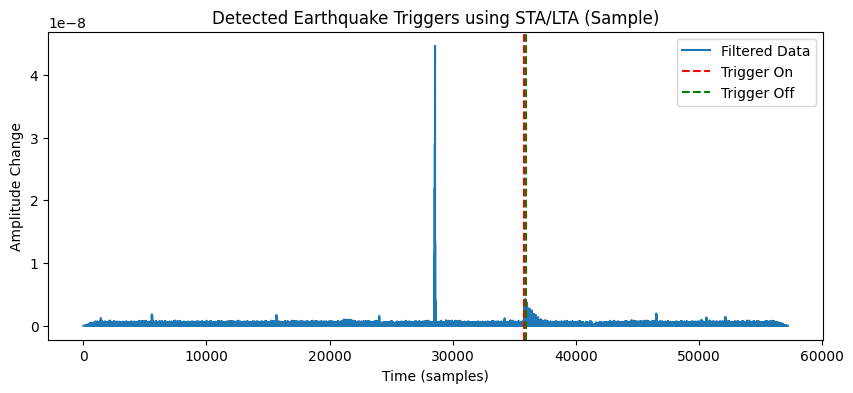

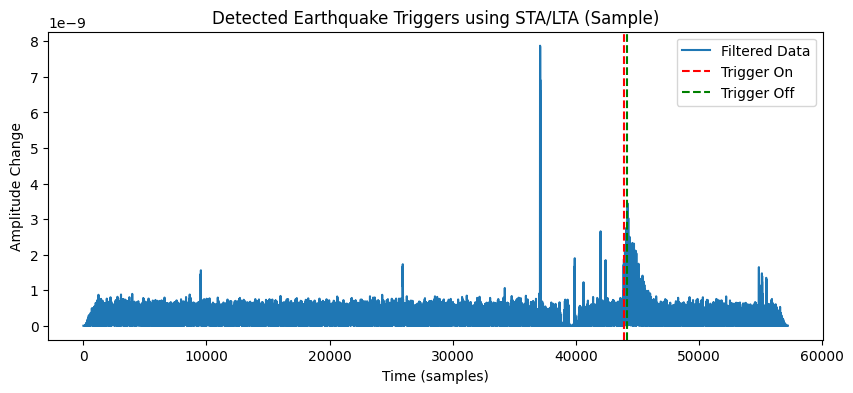

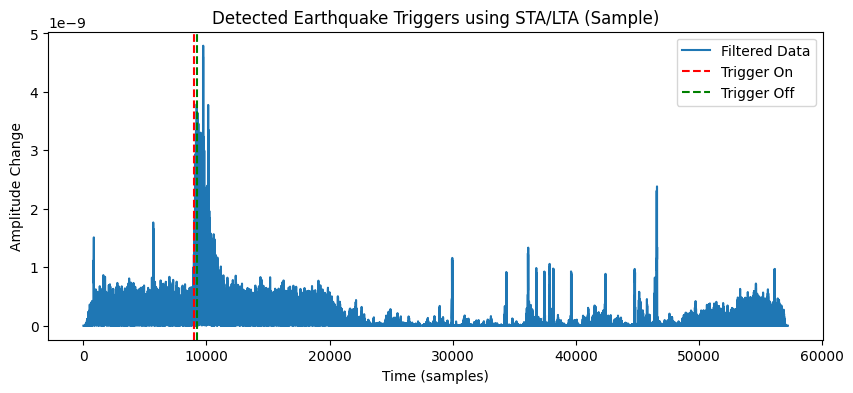

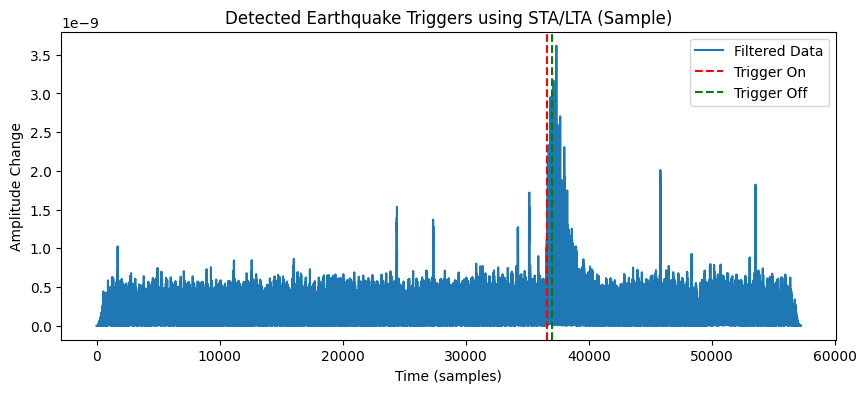

20 [[24368, 24695], [24827, 25065]]


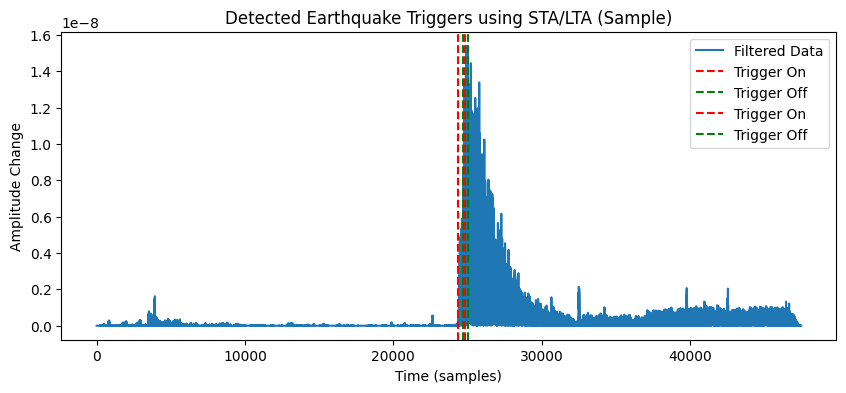

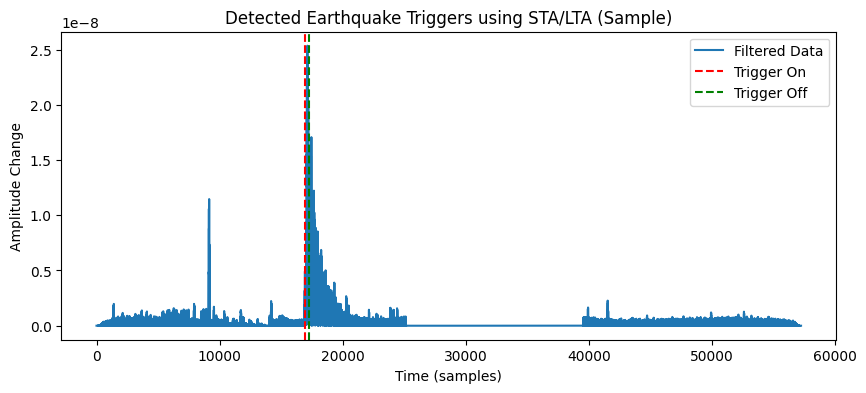

22 [[19310, 19525], [23300, 23701]]


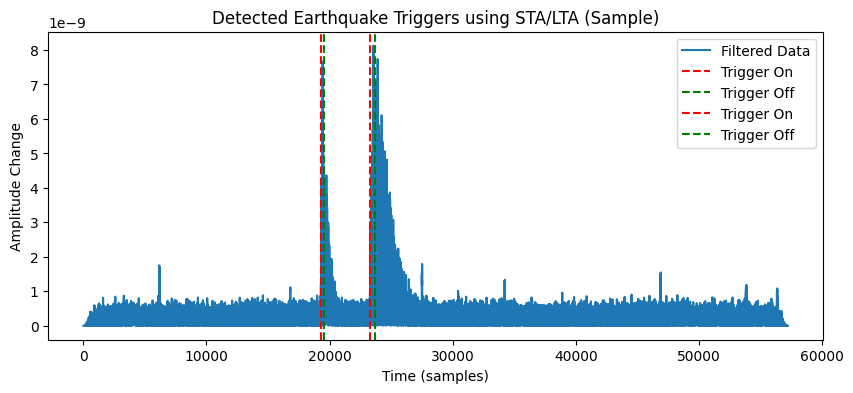

23 [[19310, 19525], [23300, 23701]]


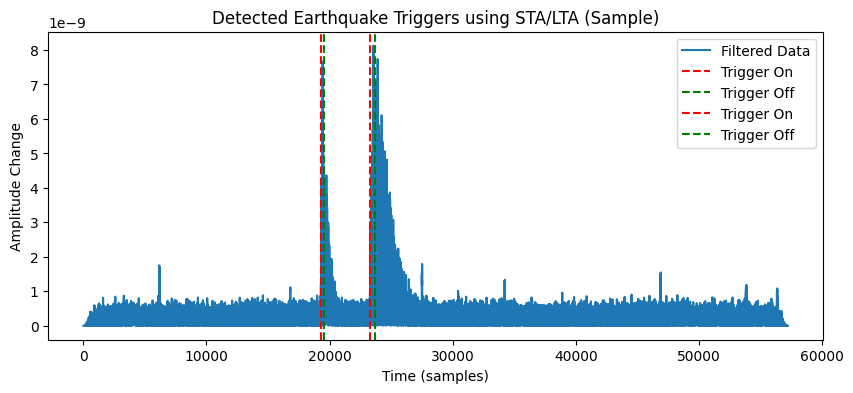

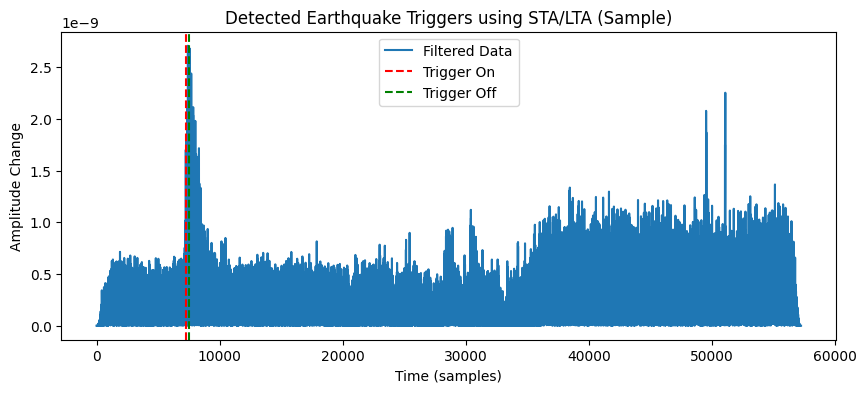

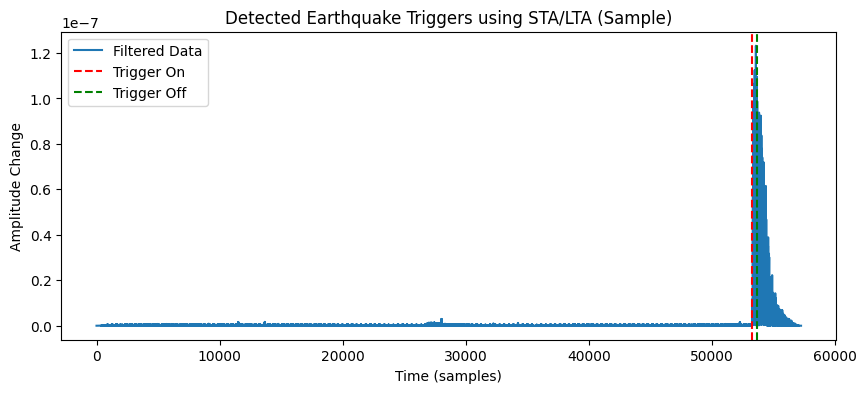

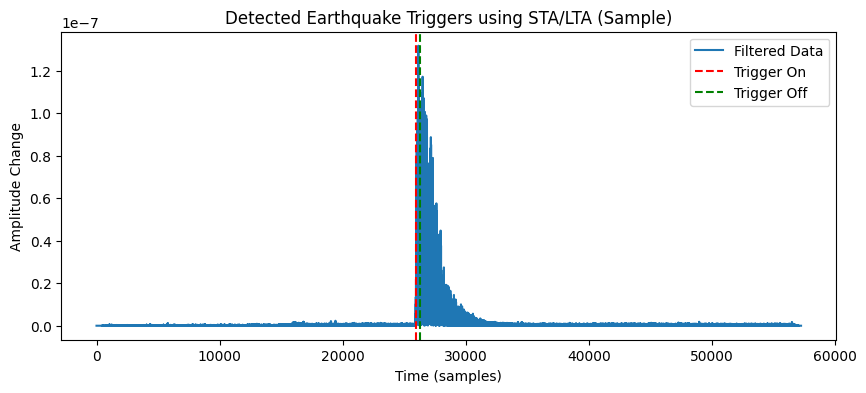

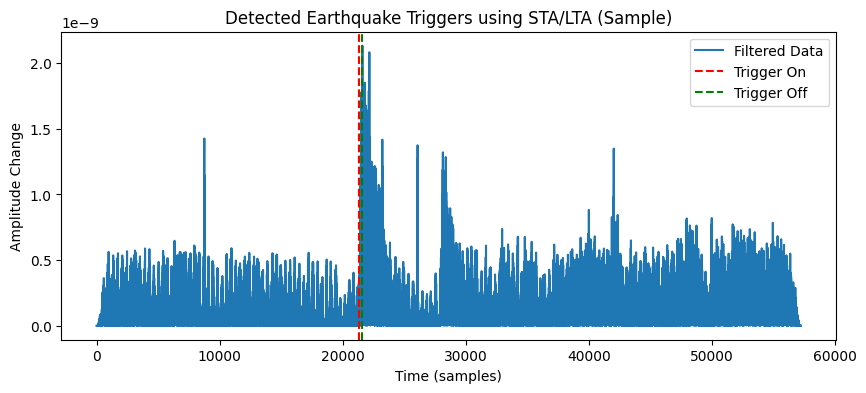

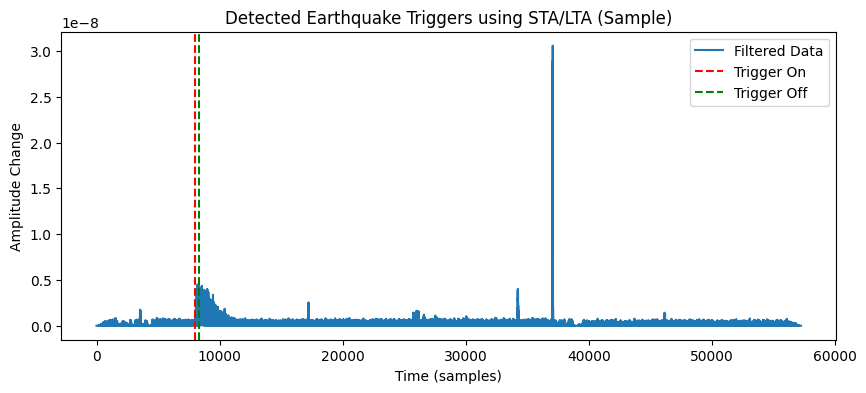

29 [[28223, 28477], [43218, 43639]]


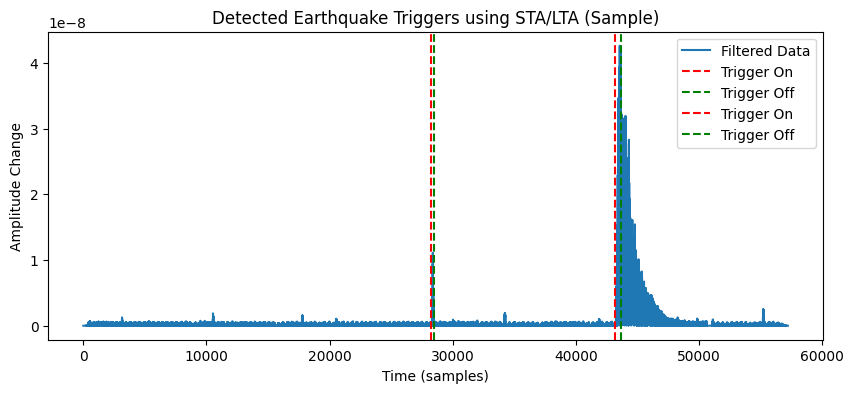

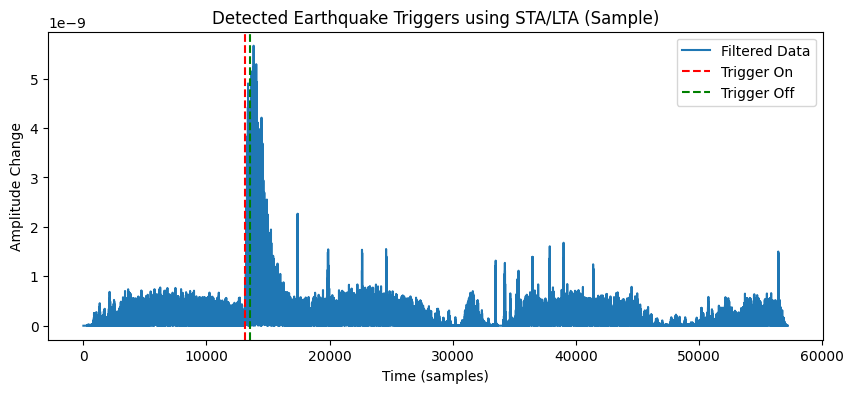

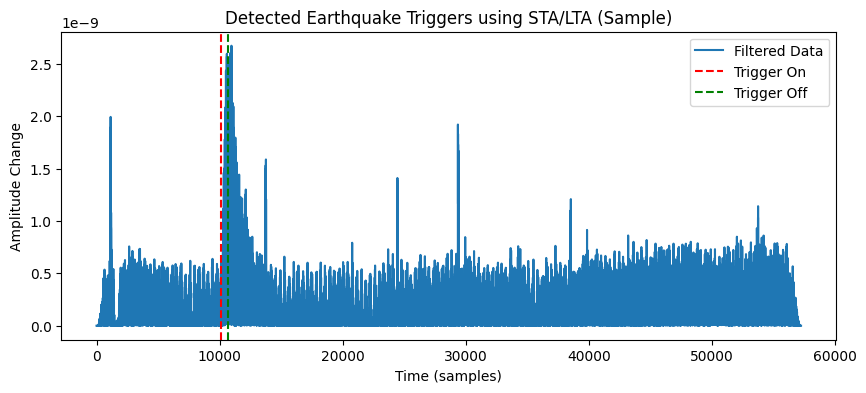

32 [[15744, 16263], [38011, 38173]]


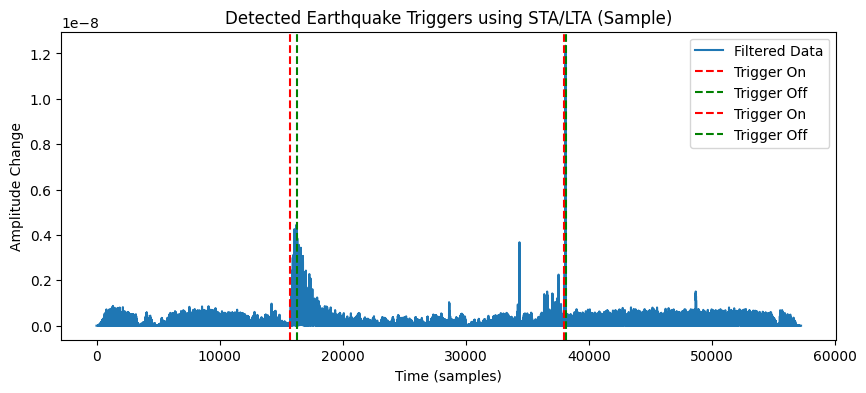

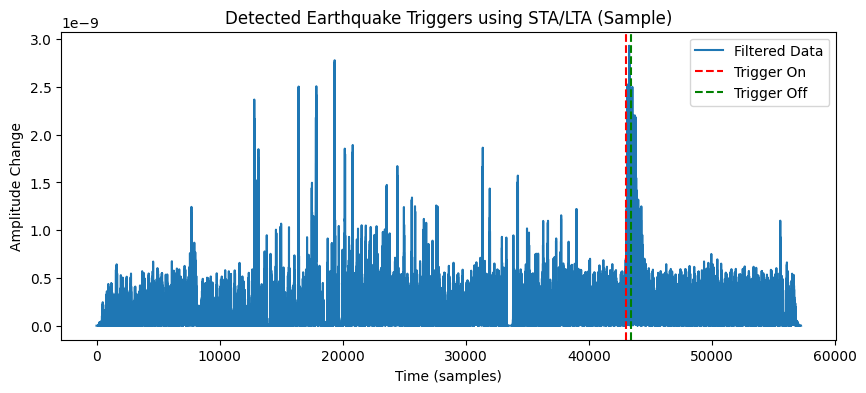

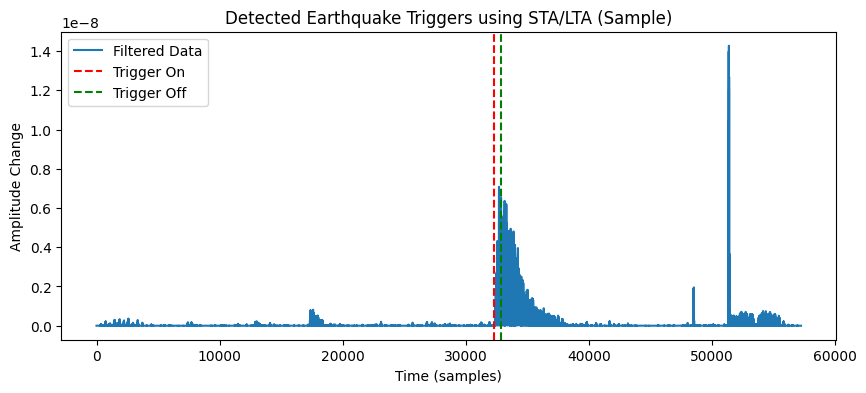

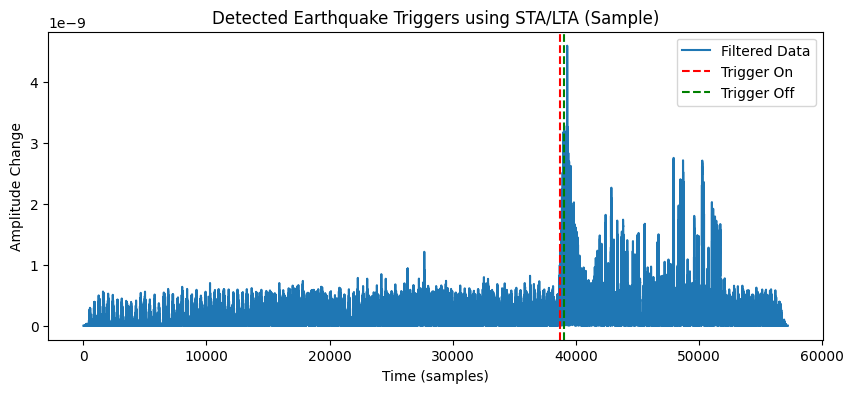

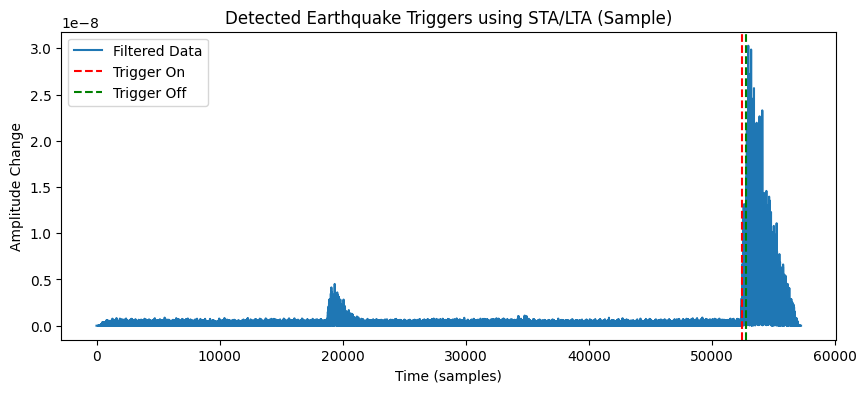

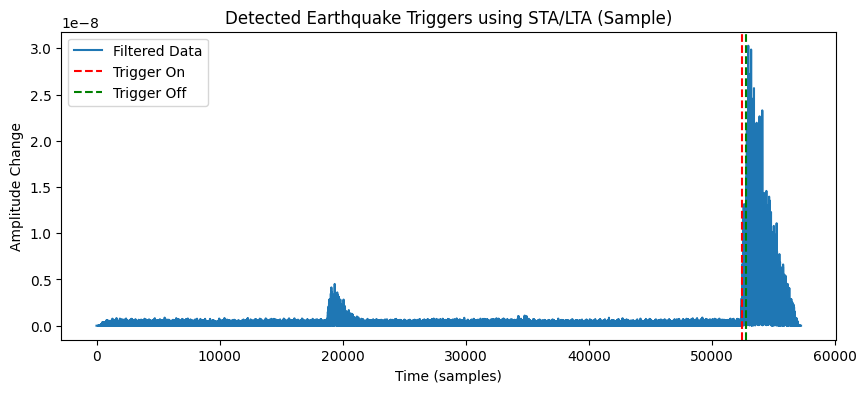

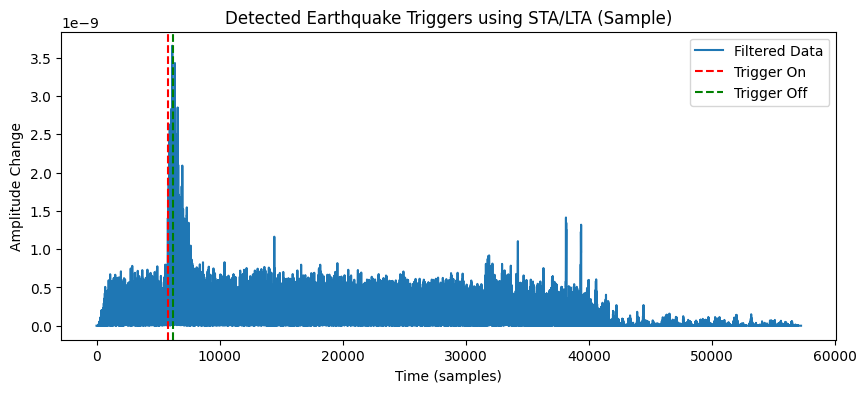

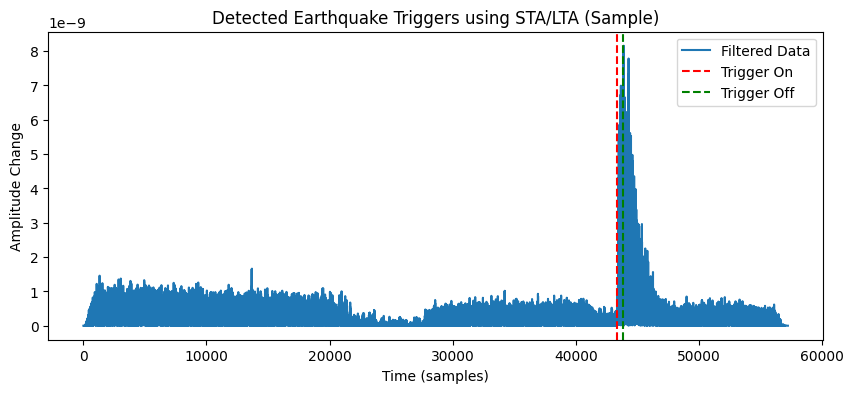

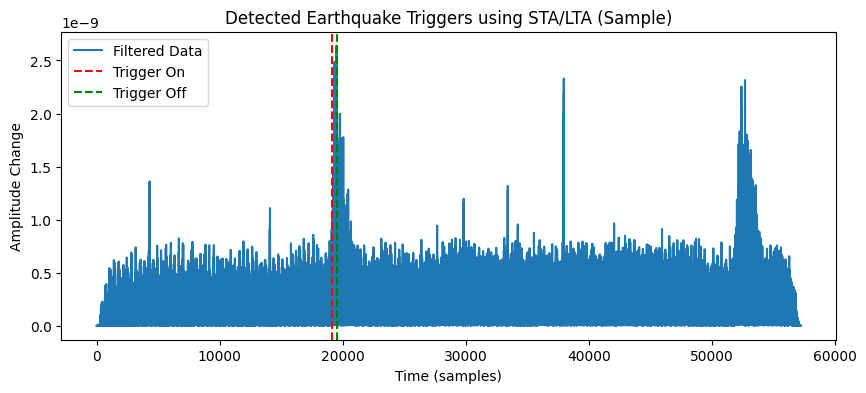

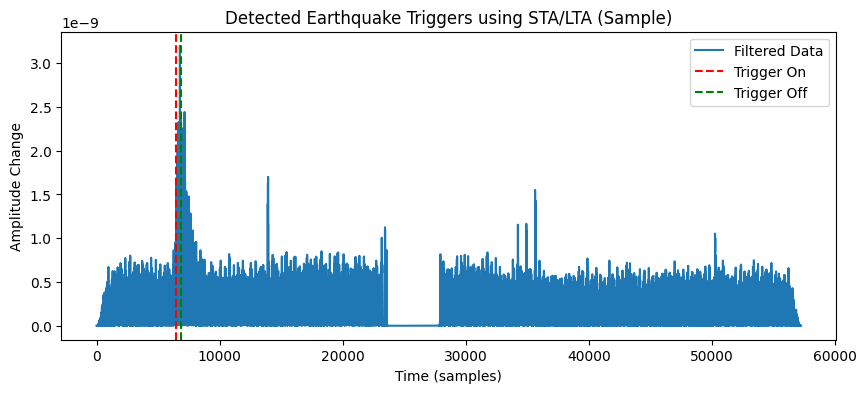

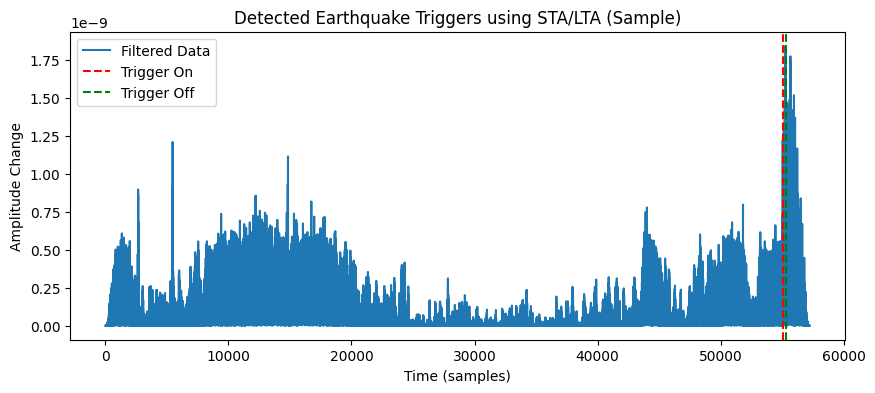

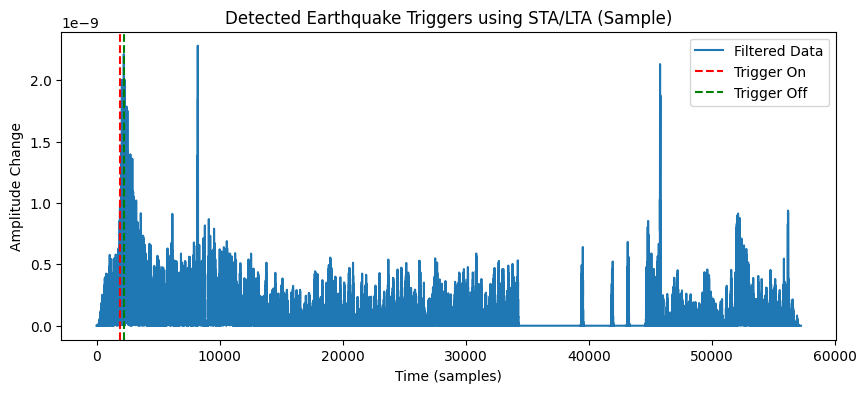

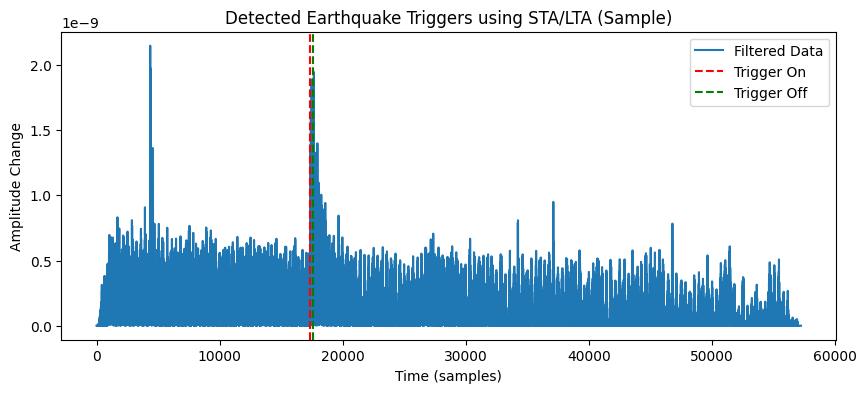

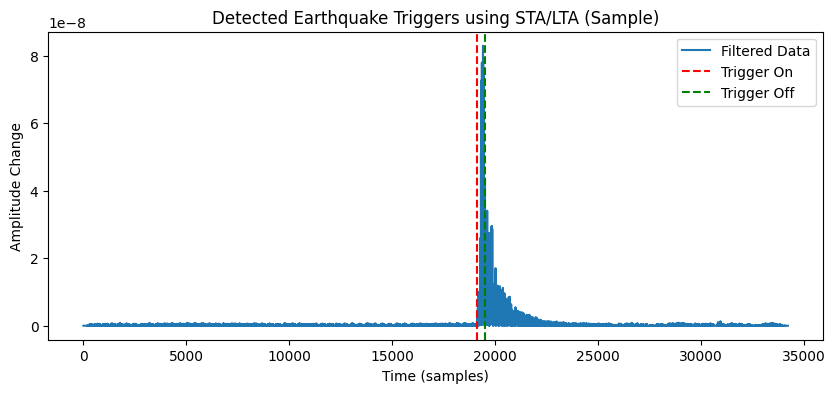

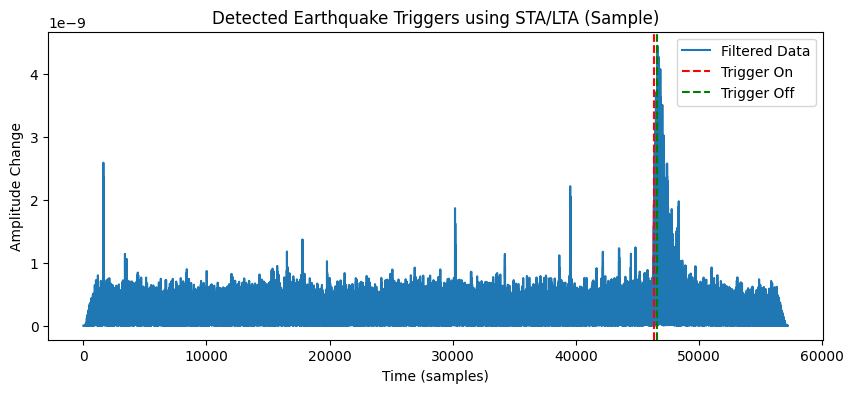

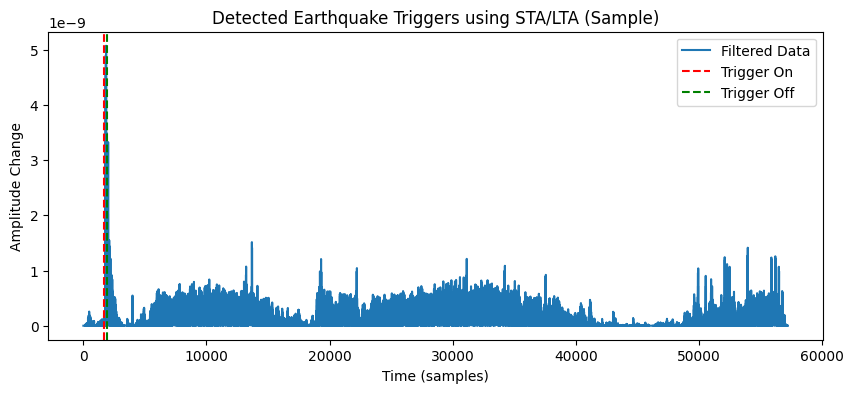

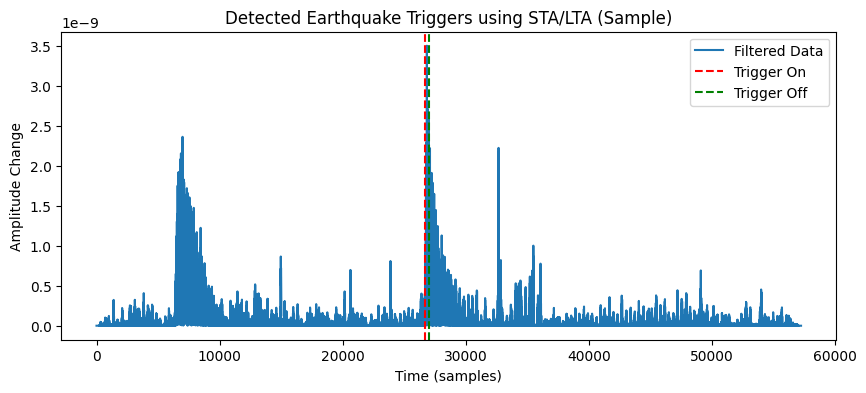

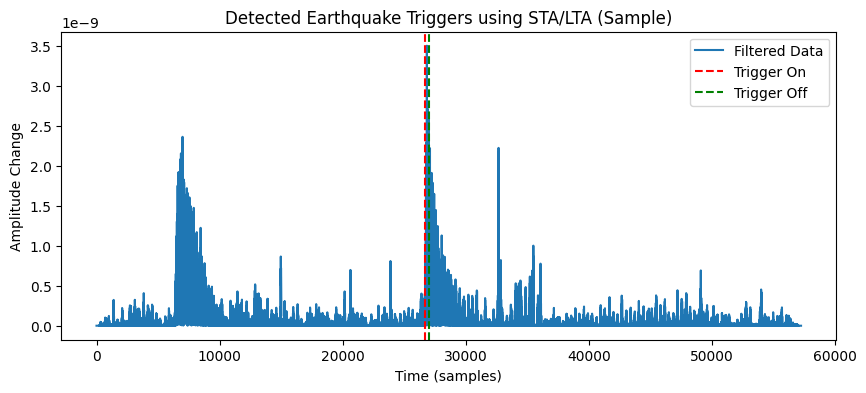

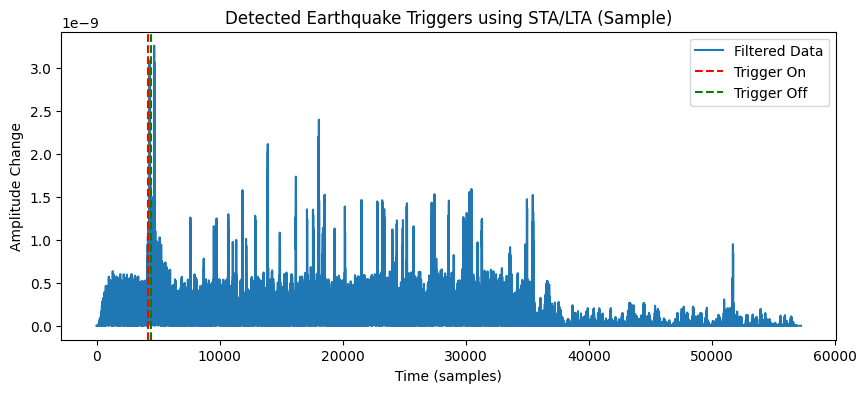

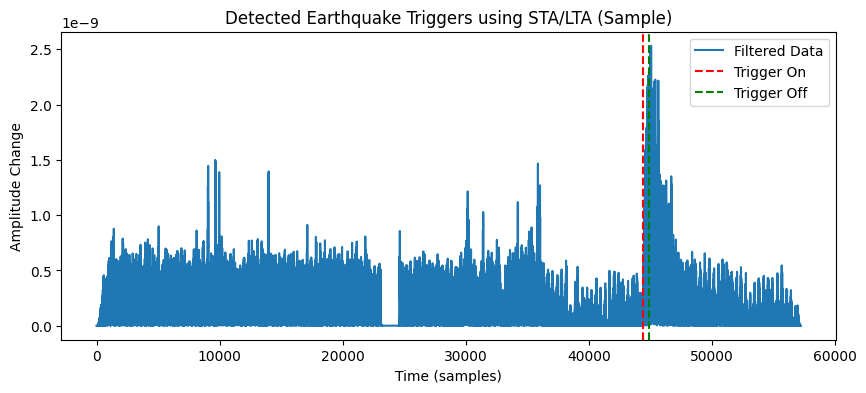

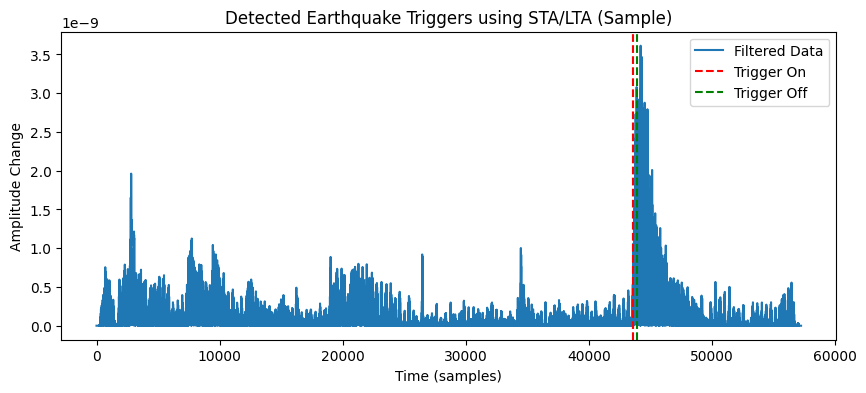

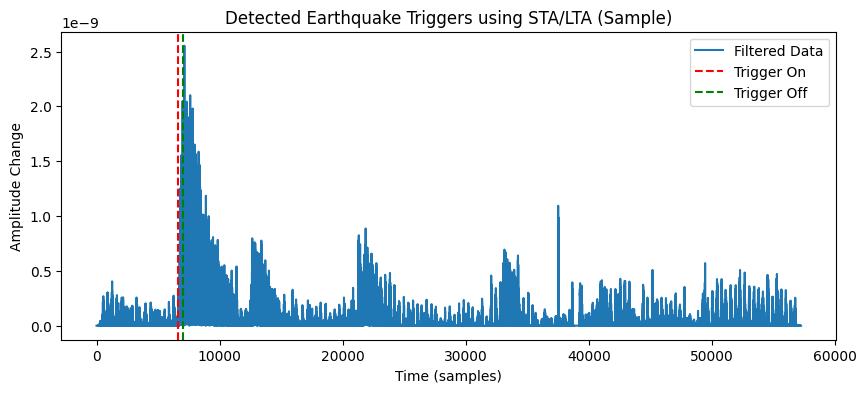

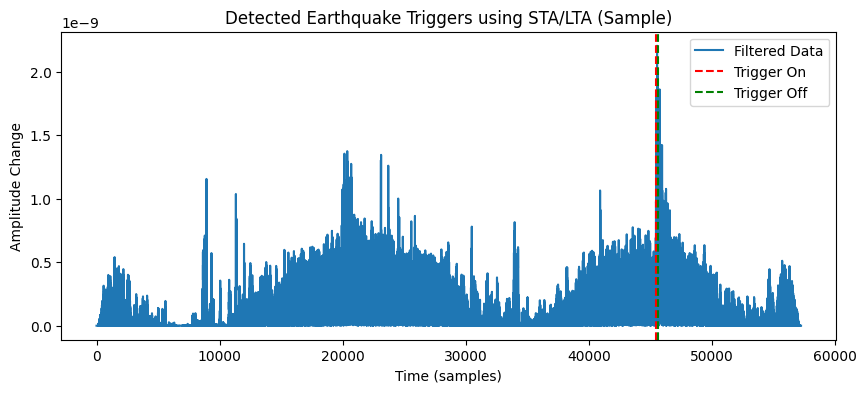

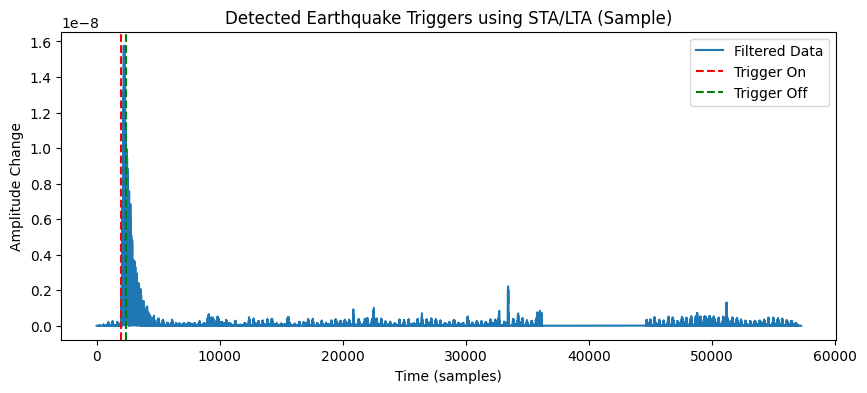

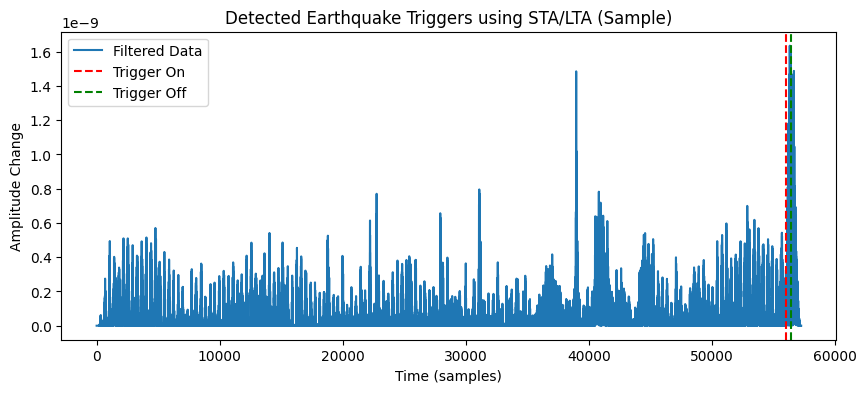

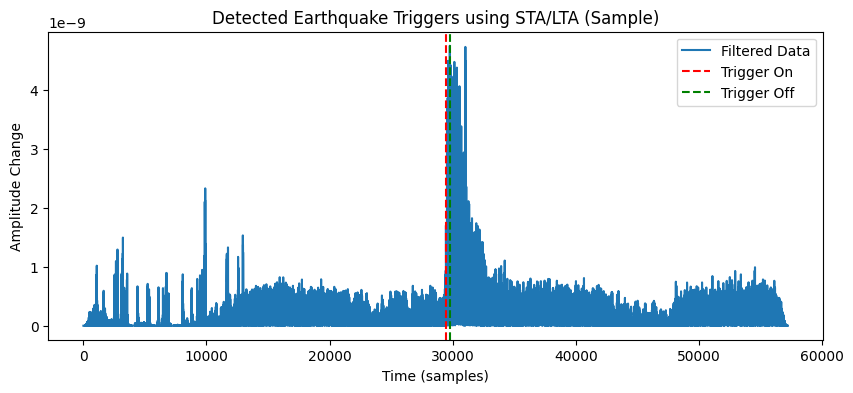

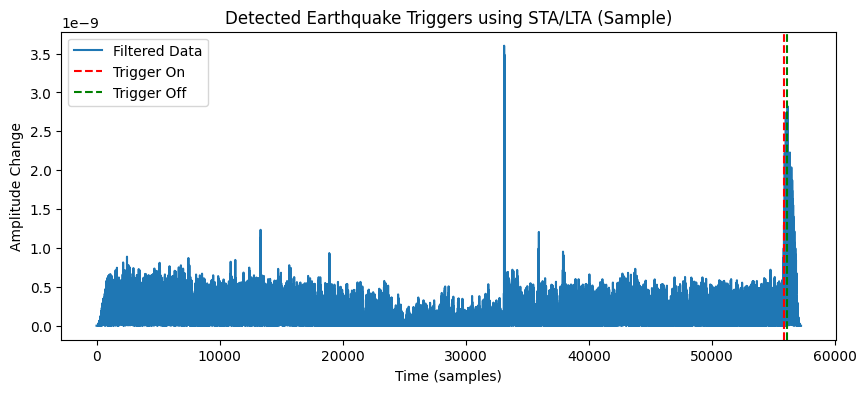

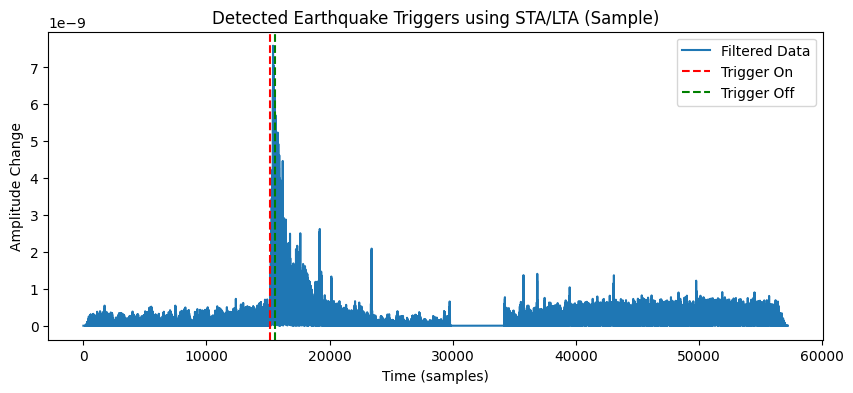

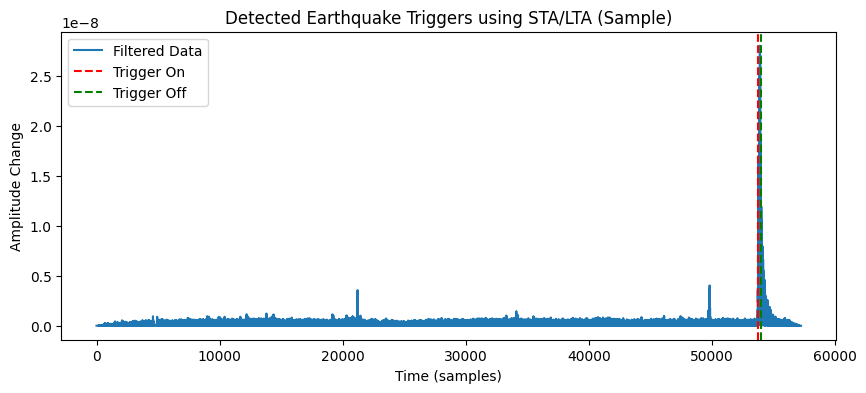

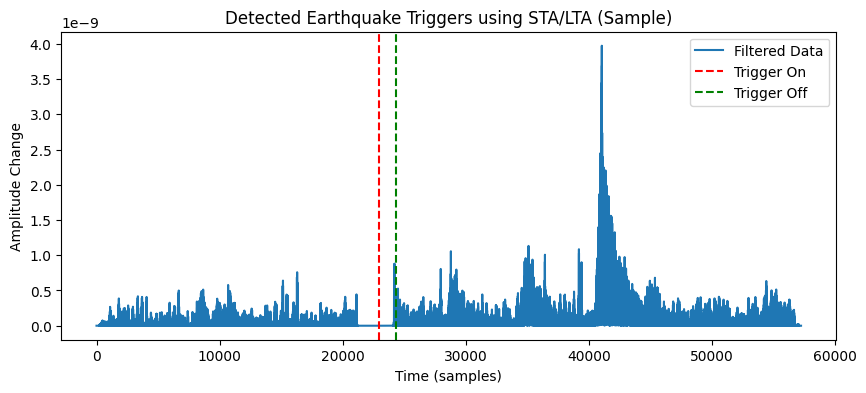

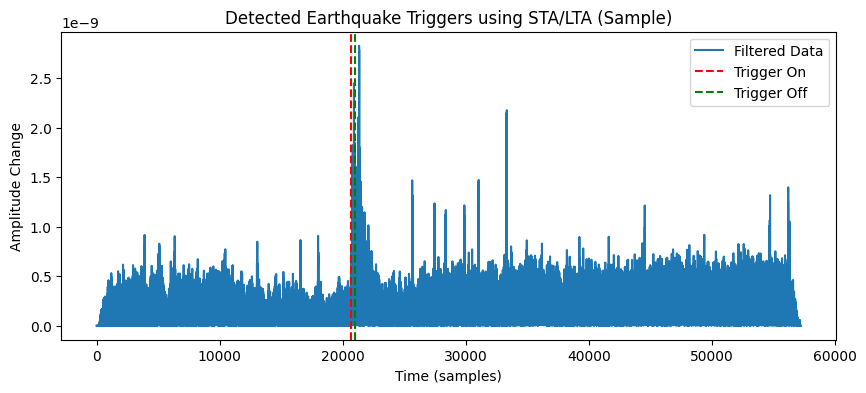

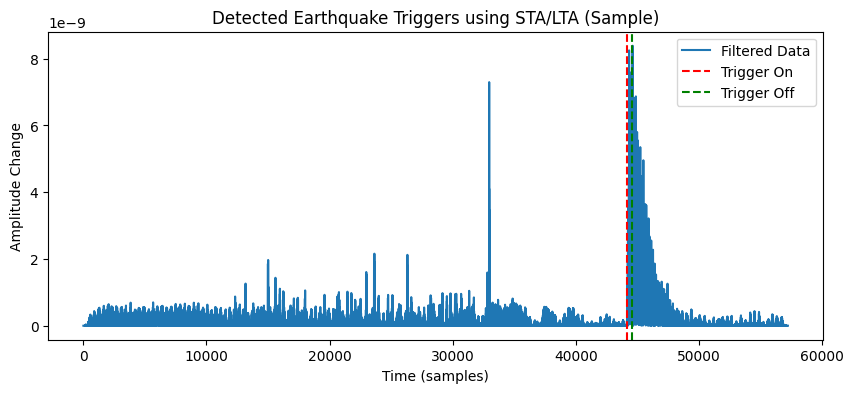

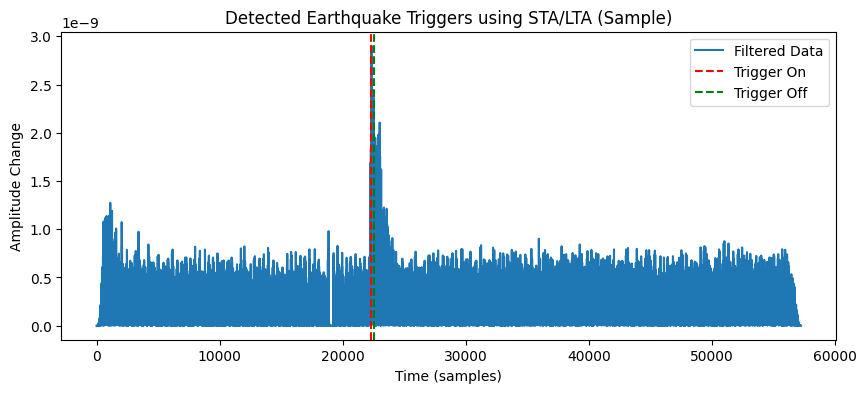

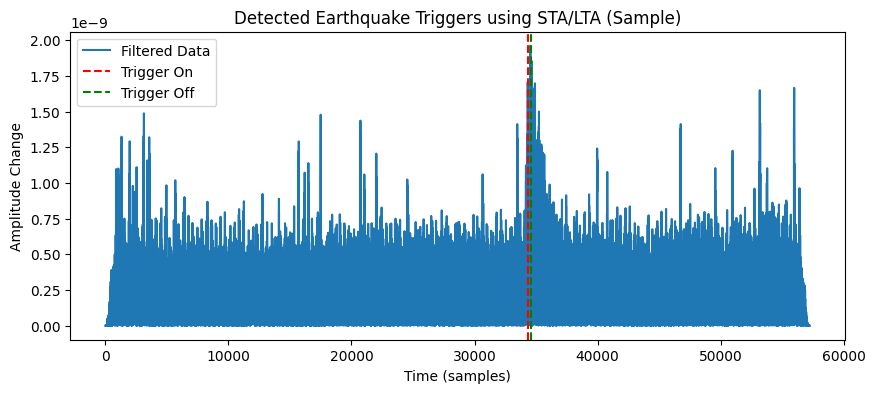

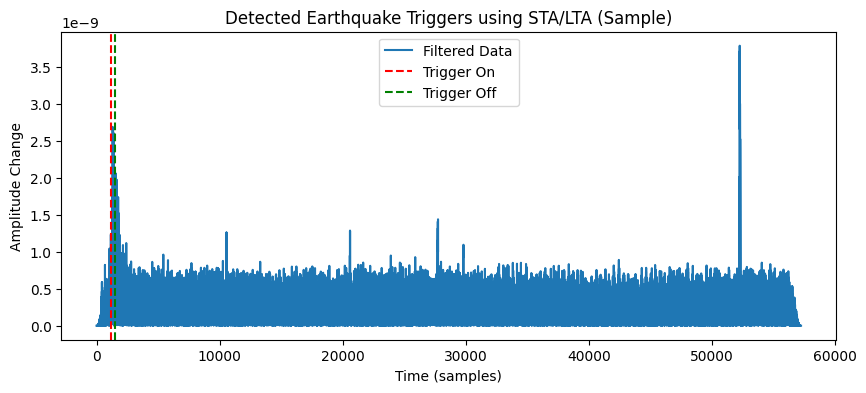

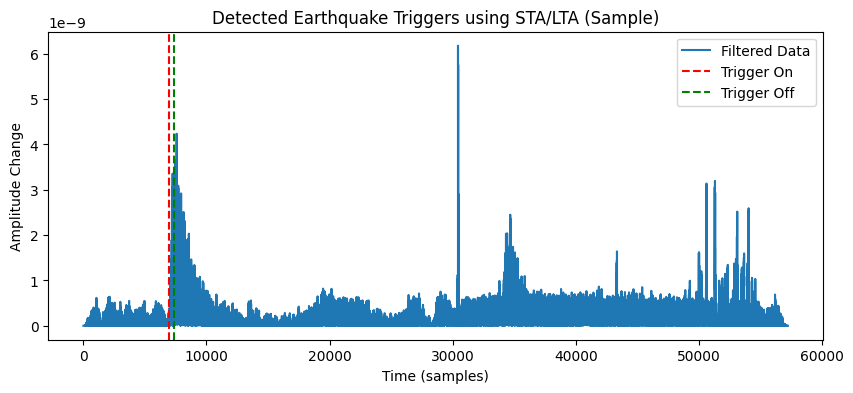

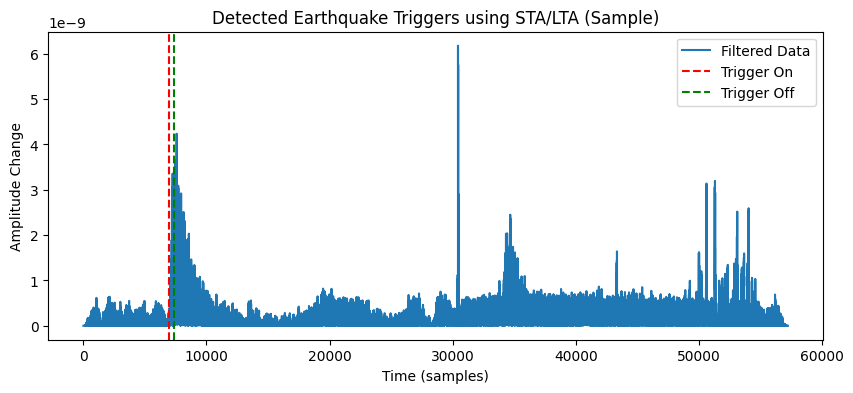

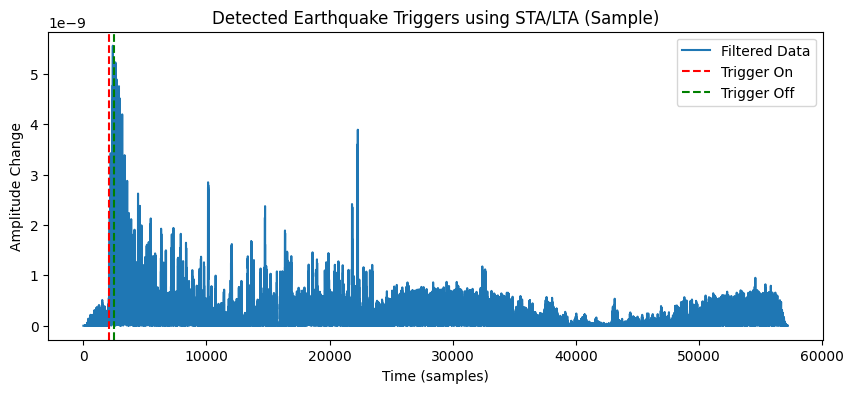

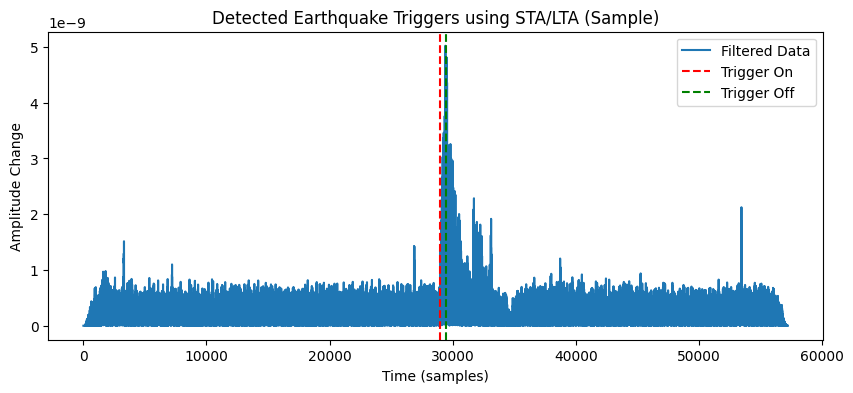

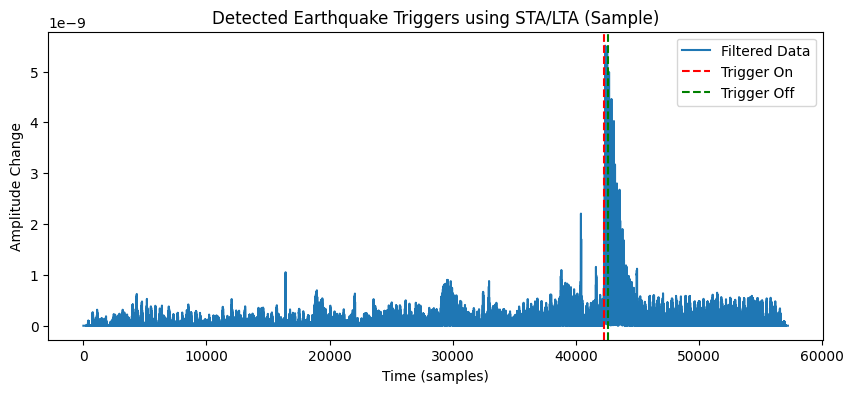

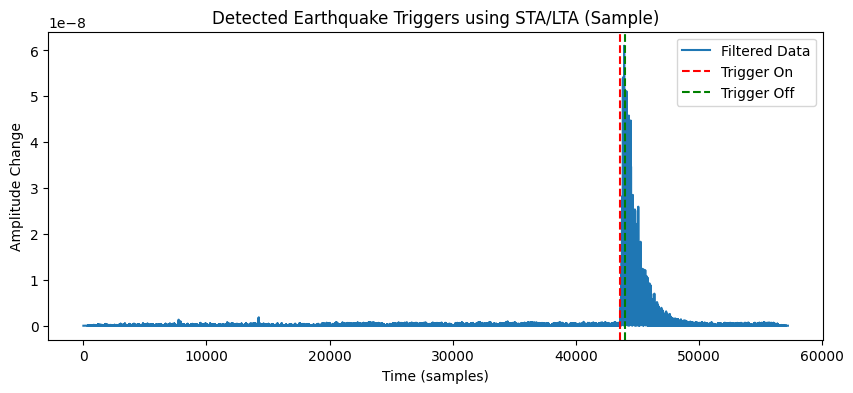

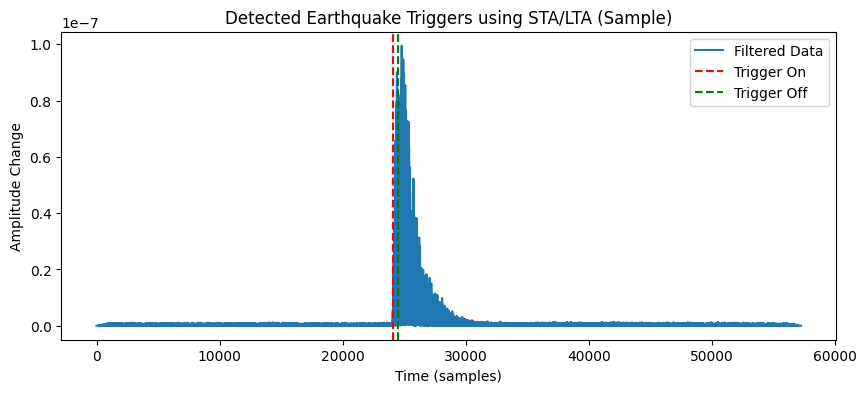

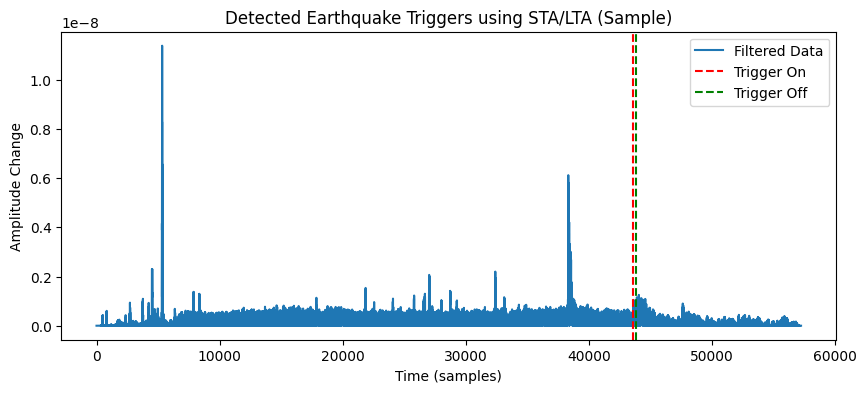

In [28]:
for i in range(len(T)):
    ans = []
    ansMax = []
    Max = -1e9
    for x in T_train[i]:
        yo = a*x[0] + b*x[1] + c*x[2]
        yo = yo.astype(np.float32)
        if yo > Max:
            Max = yo
            ansMax = x[3]
        if yo > eq_bound:
            ans.append(x[3])
    if ansMax not in ans:
        ans.append(ansMax)

    if len(ans) > 1:
        print(i, ans)

    if i >= 0:
        plt.figure(figsize=(10, 4))
        plt.plot(T[i], label='Filtered Data')
        
        for k in ans:
            plt.axvline(x=k[0], color='red', linestyle='--', label='Trigger On')
            plt.axvline(x=k[1], color='green', linestyle='--', label='Trigger Off')
        
        plt.title(f"Detected Earthquake Triggers using STA/LTA (Sample)")
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude Change')
        plt.legend()
        plt.show()

